# Titanic - Machine Learning from Disaster

Reference: Will Cukierski. Titanic - Machine Learning from Disaster. https://kaggle.com/competitions/titanic, 2012. Kaggle.

This is a practice for Classification model

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('~/Desktop/train.csv').drop(['PassengerId','Name'], axis=1)
Id = pd.read_csv('~/Desktop/test.csv')['PassengerId']
df_test = pd.read_csv('~/Desktop/test.csv').drop(['PassengerId','Name'], axis=1)

## Handle Missing Values

In [3]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
# Drop Cabin due to large volumn of missing values
df_train.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

# Drop Ticket as it Pclass already provided class info
df_train.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

In [6]:
# Fill Age missing value with its mean

age_mean = np.mean(df_train['Age'])
df_train['Age'] = df_train['Age'].fillna(age_mean)
df_test['Age'] = df_test['Age'].fillna(age_mean)

In [7]:
# Fill Embarked missing value with its mode

embarked_mode = df_train['Embarked'].mode()[0]
df_train['Embarked'] = df_train['Embarked'].fillna(embarked_mode)
df_test['Embarked'] = df_test['Embarked'].fillna(embarked_mode)

In [8]:
df_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# EDA 

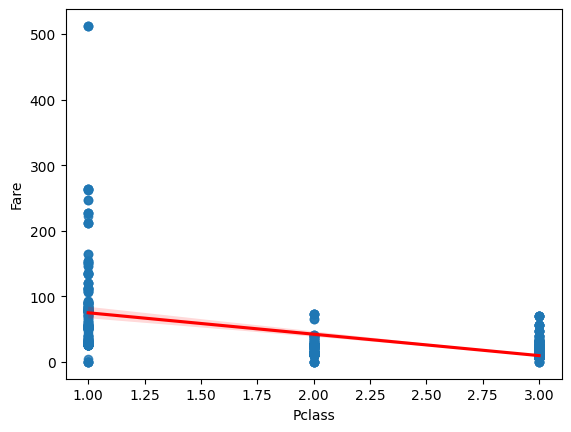

In [9]:
# relationship between passenger class and fare 
sns.regplot(data=df_train, x='Pclass', y='Fare', line_kws={'color':'r'})
plt.show()

In [10]:
df_train.groupby('Pclass').mean(numeric_only=True)

,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,
1,0.629630,37.048118,0.416667,0.356481,84.154687
2,0.472826,29.866958,0.402174,0.380435,20.662183
3,0.242363,26.403259,0.615071,0.393075,13.675550


Since the fare amount correlates with passenger class, one of them should be dropped. We should conduct an A/B test to see
dropping which one would result in a better model

In [11]:
df_train.drop('Fare', axis=1, inplace=True)
df_test.drop('Fare', axis=1, inplace=True)

## Dummy Variables

In [12]:
dummy_col = ['Pclass', 'Sex', 'Embarked']

from sklearn.preprocessing import OneHotEncoder

dummy_encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

df_train_dummy = dummy_encoder.fit_transform(df_train[dummy_col]).toarray()
df_test_dummy = dummy_encoder.transform(df_test[dummy_col]).toarray()

df_train = pd.DataFrame(df_train_dummy, columns=dummy_encoder.get_feature_names_out()).join(df_train[['Age','SibSp', 'Parch', 'Survived']])
df_test = pd.DataFrame(df_test_dummy, columns=dummy_encoder.get_feature_names_out()).join(df_test[['Age','SibSp', 'Parch']])

## Feature Scaling

In [13]:
scaling_col = ['Age', 'SibSp', 'Parch']

from sklearn.preprocessing import StandardScaler

ss_scaler = StandardScaler().set_output(transform = 'pandas')

df_train[scaling_col] = ss_scaler.fit_transform(df_train[scaling_col])
df_test[scaling_col] = ss_scaler.fit_transform(df_test[scaling_col])

## Model Fitting

### 1. Logistic Regression

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

lr_model = LogisticRegressionCV(Cs = np.logspace(-4,4,20),
                                cv = 5,
                                penalty='l2',
                                solver='liblinear',
                                scoring='accuracy',
                                max_iter=500)
lr_model = lr_model.fit(X_train, y_train)
print(f"Best C: {lr_model.C_[0]}")

y_pred = lr_model.predict(X_test)
print(f'Accuracy for logistic regression is: {accuracy_score(y_test, y_pred)}')


Best C: 29.763514416313132
Accuracy for logistic regression is: 0.8156424581005587


### Logistic Regression Model Assumption

In [25]:
# log-odds linearity
import statsmodels.api as sm


# Replace Age, SibSp, and Parch with their log-transformed versions
X_train_log = X_train.copy()
X_train_log[["Age", "SibSp", "Parch"]] = np.log(np.abs(X_train_log[["Age", "SibSp", "Parch"]]) + 1e-10)

# Add intercept column
X_train_log["constant"] = 1

# Fit logistic regression
logit_model = sm.Logit(y_train, X_train_log).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.459019
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            8
Date:                Thu, 30 Jan 2025   Pseudo R-squ.:                  0.3084
Time:                        16:34:03   Log-Likelihood:                -326.82
converged:                       True   LL-Null:                       -472.54
Covariance Type:            nonrobust   LLR p-value:                 2.736e-58
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass_2      -0.7189      0.280     -2.563      0.010      -1.269      -0.169
Pclass_3      -1.7418      0.

We only care about the continuous variables Age, SibSp, and Parch as other dummy encoded variable has no meaningful log-odds transformation. 

In [ ]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["VIF"] = [variance_inflation_factor(df_train.drop('Survived', axis=1), i) for i in range(df_train.drop('Survived', axis=1).shape[1])]
vif_data['Feature'] = df_train.drop('Survived', axis=1).columns
print(vif_data)

        VIF     Feature
0  1.845189    Pclass_2
1  3.597277    Pclass_3
2  2.755140    Sex_male
3  1.457306  Embarked_Q
4  3.858323  Embarked_S
5  1.195240         Age
6  1.256613       SibSp
7  1.275970       Parch


All features has VIF < 10, which means there is no significnat mullticollinearity

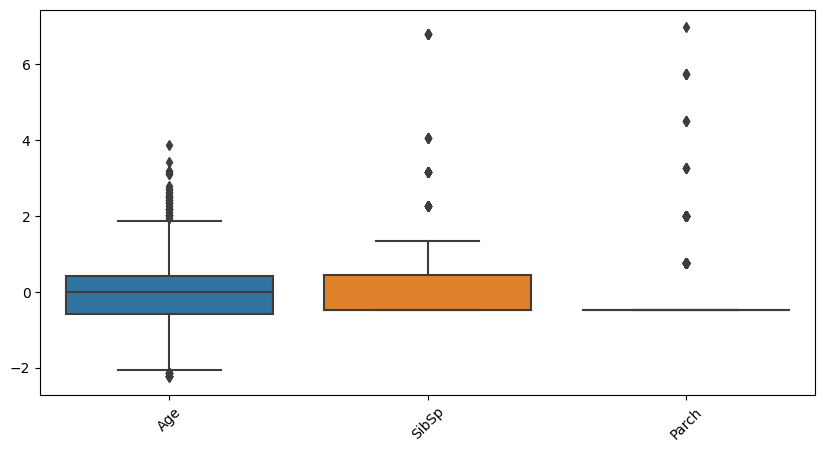

In [30]:
# Outliers
plt.figure(figsize=(10,5))
sns.boxplot(data=pd.DataFrame(df_train[['Age', 'SibSp', 'Parch']]))
plt.xticks(range(df_train[['Age', 'SibSp', 'Parch']].shape[1]), df_train[['Age', 'SibSp', 'Parch']].columns, rotation=45)
plt.show()

### 2. LDA

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

lda = LinearDiscriminantAnalysis()

lda = lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)

print(f'Accuracy for Linear Discriminant Analysis is: {accuracy_score(y_test, y_pred)}')

Accuracy for Linear Discriminant Analysis is: 0.8100558659217877


### Model Assumptions

In [31]:
# Check for Normality of Features Within Each Class

from scipy.stats import shapiro

for col in df_train[['Age', 'SibSp', 'Parch']].columns:
    stat, p = shapiro(df_train[col])
    print(f"{col}: p-value = {p}")

Age: p-value = 3.972714542180072e-15
SibSp: p-value = 5.74532370373175e-44
Parch: p-value = 2.382207389352189e-43


LDA assumes that each feature is normally distributed within each class. An p-value < 0.05 implies Feature is not normally distributed.

In [32]:
# Equal variance for target = 0 and 1
df_train_inverse = df_train.copy()
df_train_inverse[['Age', 'SibSp', 'Parch']] = ss_scaler.inverse_transform(df_train_inverse[['Age', 'SibSp', 'Parch']])
grouped = df_train_inverse.groupby("Survived")
cov_0 = grouped.get_group(0).cov()
cov_1 = grouped.get_group(1).cov()

# Compare covariance matrices
print("Covariance for Survived = 0")
print(cov_0)

print("\nCovariance for Survived = 1")
print(cov_1)

Covariance for Survived = 0
            Pclass_2  Pclass_3      Sex_male  Embarked_Q    Embarked_S  \
Pclass_2    0.145733 -0.119939  1.516693e-02   -0.013329  2.291160e-02   
Pclass_3   -0.119939  0.218858 -3.123130e-02    0.024002 -6.082725e-03   
Sex_male    0.015167 -0.031231  1.260022e-01   -0.003769  1.316870e-17   
Embarked_Q -0.013329  0.024002 -3.769295e-03    0.078424 -6.670722e-02   
Embarked_S  0.022912 -0.006083  1.316870e-17   -0.066707  1.731549e-01   
Age         0.490301 -1.976431  6.305149e-01   -0.037457 -2.260055e-01   
SibSp      -0.033682  0.065269 -7.881845e-02   -0.003004  3.641619e-02   
Parch      -0.039923  0.045197 -1.272194e-01   -0.005541  1.825683e-02   
Survived    0.000000  0.000000  0.000000e+00    0.000000  0.000000e+00   

                   Age     SibSp     Parch  Survived  
Pclass_2      0.490301 -0.033682 -0.039923       0.0  
Pclass_3     -1.976431  0.065269  0.045197       0.0  
Sex_male      0.630515 -0.078818 -0.127219       0.0  
Embarked_Q 

If covariance matrices are significantly different, LDA assumptions are violated.

In [21]:
# Multicollinearity
print(vif_data)

        VIF
0  1.889571
1  3.474712
2  2.774803
3  1.457547
4  3.852697
5  1.183448
6  1.248584
7  1.250932


### 3. KNN

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

param_grid = {
    'n_neighbors': np.arange(1, 21),
    'weights': ["uniform", "distance"],
    'metric': ["euclidean", "manhattan", "minkowski"]
}


grid_search = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid= param_grid,
    cv = 5,
    scoring= 'accuracy',
    n_jobs= -1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

knn_model = grid_search.best_estimator_
y_pred = knn_model.predict(X_test)
print(f'Accuracy for KNN is: {accuracy_score(y_test, y_pred)}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Accuracy for KNN is: 0.8100558659217877


### Model Assumptions

Since KNN is a non-parametric techinque, there is no strict model assumptions